Comparing the DG method with the Trefftz-DG method on the anisotropic mesh in 1+1 dimensions. In this case, both, Trefftz and L2 space are constructed from a space for the second order system. Since the Hessian for the L2 space is needed the following lines have to be added in the constructor for the l2 space in l2hofespace.cpp

    switch (ma->GetDimension())
    {
    case 1:
        additional_evaluators.Set ("hesse", make_shared<T_DifferentialOperator<DiffOpHesse<1>>> ());
        break;
    case 2:
        additional_evaluators.Set ("hesse", make_shared<T_DifferentialOperator<DiffOpHesse<2>>> ());
        break;
    case 3:
        additional_evaluators.Set ("hesse", make_shared<T_DifferentialOperator<DiffOpHesse<3>>> ());
        additional_evaluators.Set ("hesseboundary", make_shared<T_DifferentialOperator<DiffOpHesseBoundary<3>>> ());
        break;
    default:
        ;
    }

## Define Functions

In [1]:
import sys
sys.path.append("..")
from ngsolve import *
SetHeapSize(100*1000*1000)

from trefftzngs import *
from DGeq import *
from prodmesh import *

In [2]:
def SolveWaveeq(fes,fullsys):
    [a,f] = DGeqsys(fes,truesol,v0,sig0,c,v0,fullsys)
    [gfu, cond] = DGsolve(fes,a,f)
    
    L2error = sqrt(Integrate((truesol - gfu)*(truesol - gfu), mesh))
    
    gradtruesol = CoefficientFunction((-sig0,v0))
    sH1error = sqrt(Integrate((gradtruesol - grad(gfu))*(gradtruesol - grad(gfu)), mesh))
    
    dof=fes.ndof/(N*t_steps)
    
    return [dof,cond,L2error,sH1error]

## Run comparison

In [3]:
N = 2
c = 2
t_steps = c*N
order = 12
k = 1
D = 2

truesol =  sin( k*(c*y + x) )#exp(-pow(c*x+y,2)))#
v0 = c*k*cos(k*(c*y+x))#grad(U0)[1]
sig0 = -k*cos(k*(c*y+x))#-grad(U0)[0]

mesh = CartSquare(N,t_steps)

solution = []

for ordr in range(2,order):
    print("run order: " + str(ordr))

    btype = 0
    fes = L2(mesh, order=ordr, dgjumps=True)
    [dof,cond,L2error,sH1error] = SolveWaveeq(fes, True)
    solution.append([btype, ordr, dof,cond,L2error,sH1error])
    print("btype: " + 'L2' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

    btype = 1
    fes = FESpace("trefftzfespace", mesh, order = ordr, wavespeed = c, dgjumps=True, basistype = 0)
    [dof,cond,L2error,sH1error] = SolveWaveeq(fes, False)
    solution.append([btype,ordr,dof,cond,L2error,sH1error])
    print("btype: " + 'Trefftz' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

run order: 2
btype: L2 dof: 9.0 cond: 22.0858965165 L2error: 0.0021109488643459395 H1error: 0.022879426795052105
btype: Trefftz dof: 5.0 cond: 9.15528576465 L2error: 0.007099811851828028 H1error: 0.03997009972627439
run order: 3
btype: L2 dof: 16.0 cond: 57.1820853595 L2error: 5.07622522710062e-05 H1error: 0.0008674330050731757
btype: Trefftz dof: 7.0 cond: 30.5479974228 L2error: 0.00021086324251254636 H1error: 0.004069213513349027
run order: 4
btype: L2 dof: 25.0 cond: 152.501308821 L2error: 6.999419039883327e-07 H1error: 2.2715883278256843e-05
btype: Trefftz dof: 9.0 cond: 89.0295860955 L2error: 9.669081958997706e-06 H1error: 0.0001881794035338172
run order: 5
btype: L2 dof: 36.0 cond: 366.173287321 L2error: 1.9265720126502245e-08 H1error: 8.785176073448707e-07
btype: Trefftz dof: 11.0 cond: 315.028718804 L2error: 6.475320666801108e-07 H1error: 1.8290379040592942e-05
run order: 6
btype: L2 dof: 49.0 cond: 987.218879028 L2error: 2.308043900357357e-10 H1error: 1.2638568343930025e-08
bt

## Draw Comparison

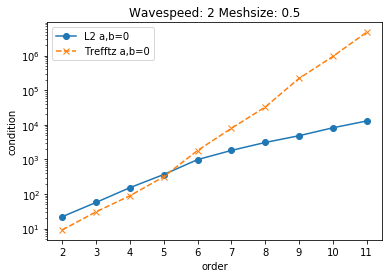

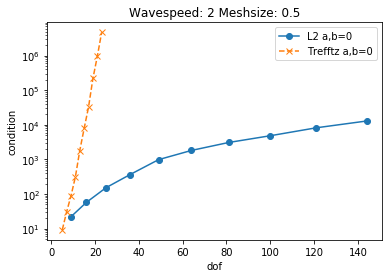

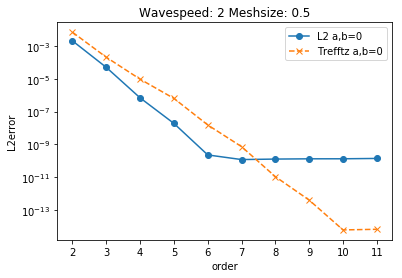

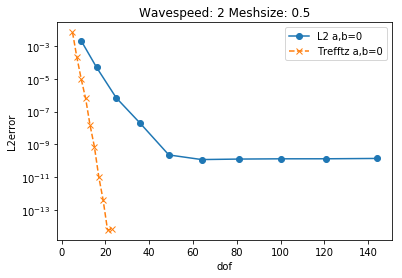

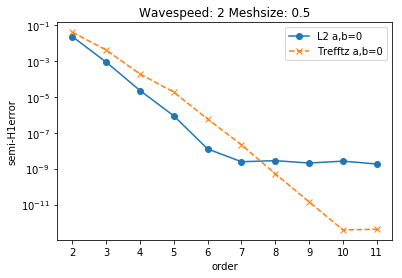

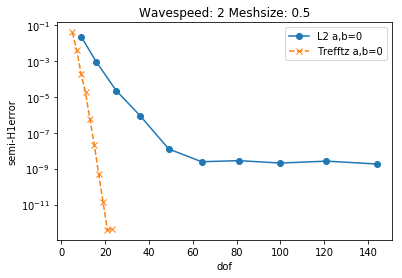

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

label = ['','order','dof','condition', 'L2error', 'semi-H1error']
sol = np.array(solution)

for yaxis in [3,4,5]:
    for xaxis in [1,2]:
        fig = plt.figure()
        ax = fig.gca()
        plt.semilogy(sol[sol[:,0]==0,xaxis], sol[sol[:,0]==0,yaxis], '-o', label="L2 a,b=0")
        plt.semilogy(sol[sol[:,0]==1,xaxis], sol[sol[:,0]==1,yaxis], '--x', label="Trefftz a,b=0")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title('Wavespeed: ' + str(c) + " Meshsize: " + str(1/N))
        plt.legend()
        plt.ylabel(label[yaxis])
        plt.xlabel(label[xaxis])
        #plt.savefig("results/pvtv3_"+label[yaxis]+label[xaxis]+".png")
        plt.show()